In [1]:
import pandas as pd
# import sqlalchemy as sql
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pickle
import json

### The relations only for (DIR='Y' or DIR IS NULL) AND (SUPPRESS='N') AND (RELA is not null). Duplicated tuples ('CUI1', 'CUI2', 'RELA') are deleted. Self links of CUI1==CUI2 are removed

In [2]:
df = pd.read_csv('data/relations.csv')

/tmp/slurm-tmp.1543478/ipykernel_890993/2527345156.py:1: DtypeWarning: Columns (9,13) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('data/relations.csv')


In [3]:
df.shape

(14548762, 16)

In [4]:
# df = df[df['DIR']=='Y']

In [5]:
df.shape

(14548762, 16)

In [6]:
df['id'] = range(len(df))

In [7]:
df.head()

,CUI1,AUI1,STYPE1,REL,CUI2,AUI2,STYPE2,RELA,RUI,SRUI,SAB,SL,RG,DIR,SUPPRESS,CVF,id
0,C0000039,A0016515,SDUI,RN,C0043950,A0137399,SDUI,mapped_to,R148171650,NaN,MSH,MSH,1.0,NaN,N,NaN,0
1,C0000039,A0016515,SDUI,RN,C0216971,A0376033,SDUI,mapped_to,R148183528,NaN,MSH,MSH,1.0,NaN,N,NaN,1
2,C0000039,A18399186,SCUI,RO,C0364349,A18182073,SCUI,has_component,R165238590,NaN,LNC,LNC,NaN,NaN,N,NaN,2
3,C0000039,A23513030,SCUI,RO,C0364349,A18182073,SCUI,measures,R167106427,NaN,LNC,LNC,NaN,NaN,N,NaN,3
4,C0000039,A0016515,SDUI,RN,C0381030,A0683149,SDUI,mapped_to,R148166148,NaN,MSH,MSH,1.0,NaN,N,NaN,4


In [8]:
# df[(df['CUI2']=='C0043950') &  (df['CUI1']=='C0000039')]

In [9]:
# df[(df['CUI2']=='C0000039') &  (df['CUI1']=='C0043950')]

In [10]:
# df['CUI1'] = df['CUI1'].astype(str)
# df['CUI2'] = df['CUI2'].astype(str)

In [11]:
# The order of concepts should be determined by the text, not from KB
df['pair'] = df[['CUI1', 'CUI2']].apply(lambda x : '{}-{}'.format(x[0],x[1]) if str(x[0])<str(x[1]) else '{}-{}'.format(x[1],x[0]), axis=1)

In [12]:
# df.head()

In [13]:
# df[df['DIR']=='Y']['pair'].nunique()
# # /1259876

In [14]:
# df[df['DIR']=='Y']['CUI2'].nunique()
# # 407584

In [15]:
# df['pair'].nunique()

In [16]:
# set(df['RELA']) - set(df[df['DIR']=='Y']['RELA'])

In [17]:
# df[df['DIR'].isna()]['SAB'].unique()

## Fix inverse RELA

### This is hard to determine directions, as the majorty has null DIR. Following https://www.nlm.nih.gov/research/umls/Snomed/snomed_represented.html, In UMLS, every source relationship is represented in two directions (e.g. is-a and inverse-is-a) in separate rows. In MRREL.RRF, those rows with DIR = 'Y' are those with the same directionality as in the source. SELECT SRUI FROM MRREL.RRF WHERE DIR = 'Y' will get all Relationship Ids. https://www.nlm.nih.gov/research/umls/implementation_resources/query_diagrams/er3.html So just use DIR = 'Y' relationships (mainly from SNOMED). Try to remove inverse pairs

#### Find inverse pairs of RELAs in UMLS

In [18]:
relas = pd.read_csv('data/rela_inverse.csv')

In [19]:
relas.head()

,DOCKEY,VALUE,TYPE,EXPL
0,RELA,abnormal_cell_affected_by_chemical_or_drug,rela_inverse,chemical_or_drug_affects_abnormal_cell
1,RELA,abnormality_associated_with_allele,rela_inverse,allele_has_abnormality
2,RELA,access_device_used_by,rela_inverse,uses_access_device
3,RELA,access_instrument_of,rela_inverse,has_access_instrument
4,RELA,access_of,rela_inverse,has_access


In [20]:
relas.shape

(910, 4)

In [21]:
invers = pd.Series(relas.EXPL.values,index=relas.VALUE).to_dict()

In [22]:
len(invers)

910

In [23]:
# relas['pair'] = relas[['EXPL', 'VALUE']].apply(lambda x : 
#                                                 '{}-{}'.format(x[0],x[1]) if str(x[0])<str(x[1]) else 
#                                                 '{}-{}'.format(x[1],x[0]), axis=1)

In [24]:
# relas['pair'].unique()

In [25]:
466*2-910

22

#### Order RELA based on frequency, left direction often has a higher frequency than right direction

In [26]:
rels_order = df['RELA'].value_counts().reset_index()

In [27]:
rels_order

,index,RELA
0,isa,1725865
1,inverse_isa,1174130
2,sib_in_isa,545046
3,mapped_to,540915
4,mapped_from,440202
...,...,...
817,larger_than,1
818,external_to,1
819,has_excluded_approach,1
820,chromosomal_location_of_wild-type_gene,1


In [28]:
rels_order['len'] = rels_order['index'].str.len()
rels_order['by'] = rels_order['index'].str.contains('by')
rels_order['has'] = rels_order['index'].str.contains('has')

In [29]:
rels_order = rels_order.sort_values(by=['RELA','len', 'has', 'by'], ascending = (False, True, False, True))

In [30]:
# rels_order = rels_order.sort_values(by=['len'], ascending = (True))

In [31]:
rels_order

,index,RELA,len,by,has
0,isa,1725865,3,False,False
1,inverse_isa,1174130,11,False,False
2,sib_in_isa,545046,10,False,False
3,mapped_to,540915,9,False,False
4,mapped_from,440202,11,False,False
...,...,...,...,...,...
800,has_possibly_included_panel_element,1,35,False,True
810,route_of_administration_of_excluded,1,35,False,False
814,has_excluded_route_of_administration,1,36,False,True
820,chromosomal_location_of_wild-type_gene,1,38,False,False


In [32]:
# rels_order[rels_order['index'].isin(['may_be_treated_by', 'may_treat',
#                                      'gene_mutant_encodes_gene_product_sequence_variation',
#                                     'gene_product_sequence_variation_encoded_by_gene_mutant',
#                                      'is_marked_by_gene_product',
#                                      'gene_product_is_biomarker_of',
#                                      'has_excluded_locale', 
#                                      'locale_of_excluded',
#                                      'replaced_by',
#                                      'replaces'
#                                     ])]

In [33]:
lefts = set()
for index, row in rels_order.iterrows():
    if (row['index'] not in lefts) & (invers[row['index']] not in lefts):
        lefts.add(row['index'])

In [34]:
rels_order.head(20)

,index,RELA,len,by,has
0,isa,1725865,3,False,False
1,inverse_isa,1174130,11,False,False
2,sib_in_isa,545046,10,False,False
3,mapped_to,540915,9,False,False
4,mapped_from,440202,11,False,False
6,inactive_ingredient_of,393580,22,False,False
5,has_inactive_ingredient,393580,23,False,True
7,ingredient_of,274003,13,False,False
8,has_ingredient,274003,14,False,True
9,classifies,254824,10,False,False


In [35]:
len(lefts)

441

In [36]:
# lefts

In [37]:
55 - 5 - 7 - 13 - 30

0

In [38]:
# lefts2 = lefts.copy()

In [39]:
# lefts2 - lefts

In [40]:
# lefts - lefts2

### Only use 25 important relations from SemRep: https://bmcbioinformatics.biomedcentral.com/articles/10.1186/s12859-020-3517-7

The semnatic types in semantic networks are different from relation attributes in RELA

In [41]:
# chose_rels = [i.strip().lower() for i in '''ADMINISTERED_TO | AFFECTS | ASSOCIATED_WITH |
# 	          AUGMENTS | CAUSES | COEXISTS_WITH | CONVERTS_TO |
# 	          COMPLICATES | DIAGNOSES | DISRUPTS | INHIBITS |
# 	          INTERACTS_WITH | ISA | LOCATION_OF | MANIFESTATION_OF | 
# 	          METHOD_OF | OCCURS_IN | PART_OF | PRECEDES|
# 	          PREDISPOSES | PREVENTS | PROCESS_OF | PRODUCES | 
# 	          STIMULATES | TREATS | USES | 
# 	          compared_with | higher_than | lower_than | same_as''' .split('|')]


In [42]:
# len(chose_rels)

In [43]:
# chose_rels

In [44]:
# set(chose_rels) - set(lefts)

#### No change on pair size after removing right directions

In [45]:
df['pair'].nunique()

7363893

In [46]:
df2 = df.copy()

In [47]:
df[df['RELA'].isin(lefts)]['pair'].nunique()

7363893

In [48]:
df[df['RELA'].isin(lefts)].shape

(8377727, 18)

In [128]:
# dirs = df[df['DIR']=='Y']['RELA'].unique()
# inv_dirs = relas[relas['VALUE'].isin(dirs)]['EXPL'].unique()
# sys_dirs = relas[relas['VALUE']==relas['EXPL']]['VALUE'].unique()

In [49]:
df = df[df['RELA'].isin(lefts)]

In [130]:
df.shape

(8377727, 18)

#### remove duplications in symmetrical pairs such as sib_in_isa

In [51]:
df = df.drop_duplicates(['pair', 'RELA'], keep='first')

In [53]:
df.shape

(7926419, 18)

In [54]:
df['pair'].nunique()

7363893

In [133]:
df['pair'].nunique()

7363893

In [55]:
df['RELA'].nunique()

441

### Some CUI pairs have multiple relations, so combine them together as a single relationships or multiple label classifications

In [64]:
# df = df2

In [56]:
pair_counts = df.groupby(['pair'])['id'].count().reset_index()

In [57]:
# pair_counts.head()

In [58]:
pair_counts['id'].value_counts()

1    6861886
2     457977
3      33671
4       6317
5       2323
6       1353
7        363
8          3
Name: id, dtype: int64

#### Single-relation pairs

In [59]:
6861886/(df['id'].nunique())

0.8656981166400616

In [60]:
# pair_counts[pair_counts['id']==7]

In [61]:
# df[df.duplicated(subset=['CUI1','CUI2'], keep=False)]

In [62]:
df[(df['CUI1']=='C0002403') &  (df['CUI2']=='C0936072')]

,CUI1,AUI1,STYPE1,REL,CUI2,AUI2,STYPE2,RELA,RUI,SRUI,SAB,SL,RG,DIR,SUPPRESS,CVF,id,pair
76314,C0002403,A2878327,SCUI,RO,C0936072,A13900951,SCUI,has_active_ingredient,R126262215,NaN,MEDCIN,MEDCIN,NaN,NaN,N,NaN,76314,C0002403-C0936072
76315,C0002403,A29506299,SCUI,RO,C0936072,A22812364,SCUI,replaced_by,R141855271,38b1bbb0-b4c2-573b-8fd1-5e502a4c9ec8,SNOMEDCT_US,SNOMEDCT_US,NaN,Y,N,NaN,76315,C0002403-C0936072
76316,C0002403,A29506299,SCUI,SY,C0936072,A23052165,SCUI,same_as,R142499659,a21e4e78-aab8-5ec4-859d-078d79cb2cf3,SNOMEDCT_US,SNOMEDCT_US,NaN,Y,N,NaN,76316,C0002403-C0936072
76317,C0002403,A29506299,SCUI,RN,C0936072,A13900951,SCUI,isa,R150123625,NaN,MEDCIN,MEDCIN,NaN,NaN,N,NaN,76317,C0002403-C0936072
76319,C0002403,A2878327,SCUI,RO,C0936072,A2990781,SCUI,is_modification_of,R179114224,9247066020,SNOMEDCT_US,SNOMEDCT_US,0.0,Y,N,NaN,76319,C0002403-C0936072
76320,C0002403,A10334614,SCUI,RN,C0936072,A16788376,SCUI,form_of,R45060343,NaN,RXNORM,RXNORM,NaN,NaN,N,4096.0,76320,C0002403-C0936072


In [48]:
pair_counts = pair_counts[pair_counts['id'] == 1]

In [49]:
pair_counts['id'].value_counts()

1    6861886
Name: id, dtype: int64

In [50]:
pair_counts = pair_counts.drop(columns=['id'])

In [51]:
df.shape

(7926419, 18)

In [157]:
# df2 = df

In [158]:
# df2.shape

In [159]:
# df = df2.merge(pair_counts, how="inner", left_on=["pair"], right_on=["pair"])

In [160]:
# df.shape

In [56]:
# df.head()

In [161]:
# df.groupby(['CUI1','CUI2'])['id'].count().reset_index()['id'].value_counts()

### Some inverse pairs do not have inverse relations

In [58]:
# pair_counts = df.groupby(['pair'])['id'].count().reset_index()

In [59]:
# pair_counts['id'].value_counts()

In [60]:
# pair_counts[pair_counts['id']==2]

In [61]:
# df[df['pair']=='C0000294-C0721681']

In [62]:
# pair_counts

In [63]:
# rel_counts = (df.groupby(['RELA'])['id'].count().reset_index().sort_values('id', ascending=False))

In [66]:
plt.rcParams['figure.figsize'] = [16.0, 10.0]

In [67]:
common_relas = pd.value_counts(df['RELA']).iloc[:50].index

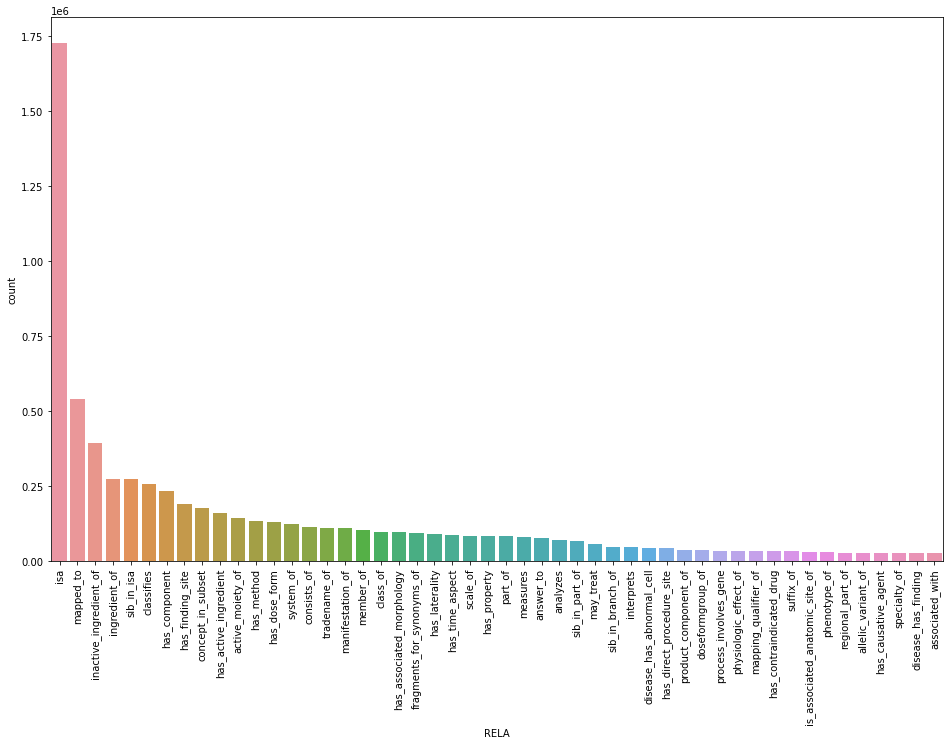

In [68]:
sns.countplot(x="RELA", data=df, order=common_relas)
plt.xticks(rotation=90)
plt.show()

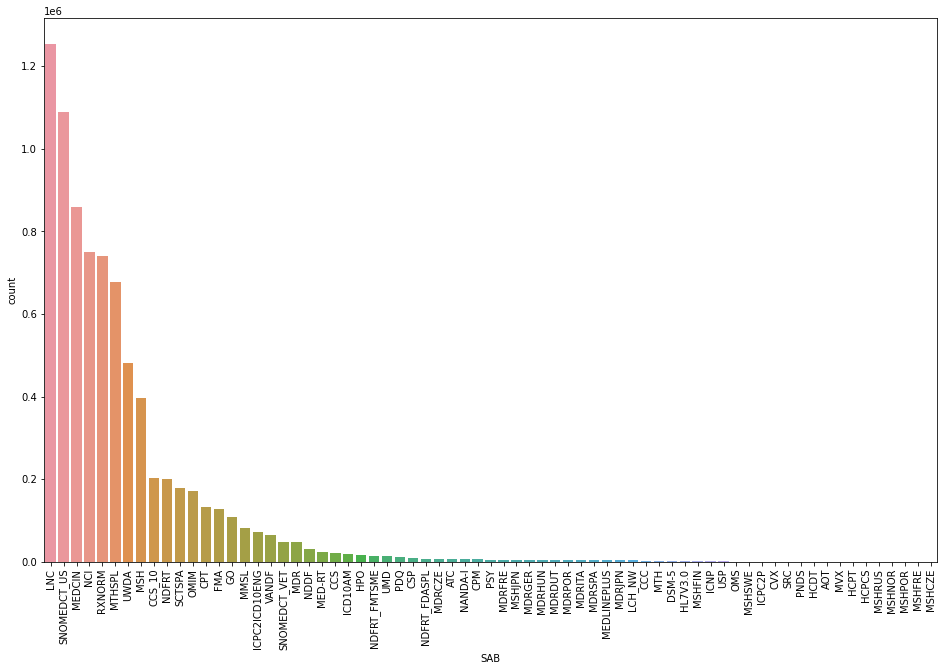

In [69]:
sns.countplot(x="SAB", data=df, order=pd.value_counts(df['SAB']).index)
plt.xticks(rotation=90)
plt.show()

In [162]:
mt_counts = df[df['RELA'].isin(common_relas)].groupby(['SAB','RELA'])['id'].count().reset_index()

In [163]:
mt_counts.head()

,SAB,RELA,id
0,ATC,isa,1161
1,ATC,member_of,4884
2,CCS,classifies,21944
3,CCS_10,classifies,201868
4,CPM,isa,3827


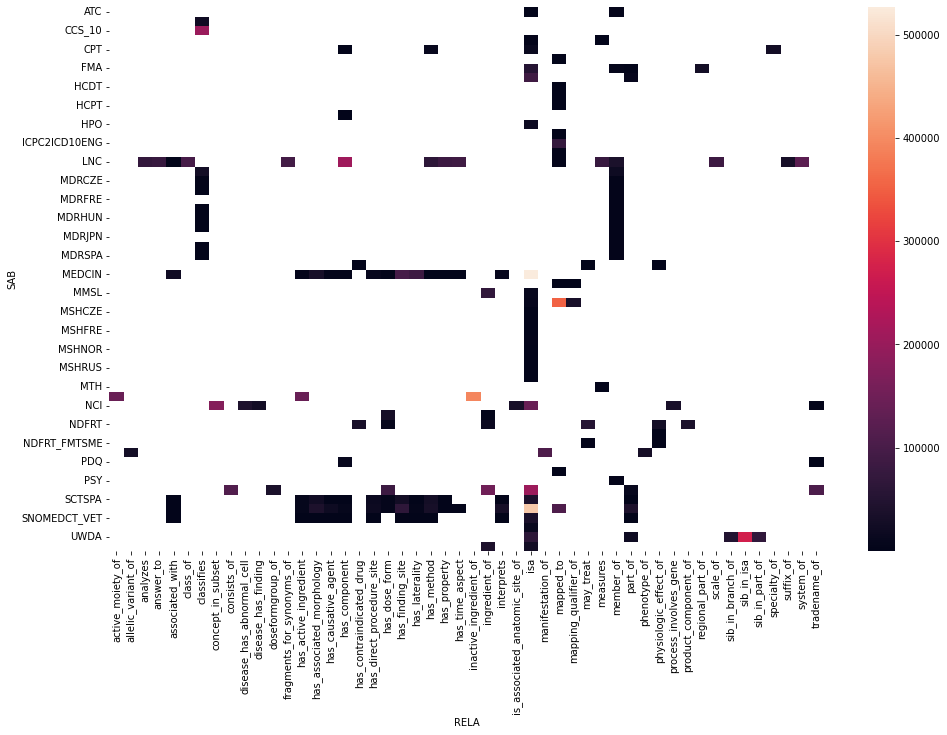

In [164]:
flights = mt_counts.pivot('SAB', 'RELA', 'id')
sns.heatmap(flights)
plt.show()
# plt.savefig('data/')

### Export results

### The directionality of a relationship row is interpreted left-to-right in SNOMED CT but right-to-left in the Metathesaurus. This means that ConceptId1 in the RELATIONSHIPS table will correspond to AUI2/CUI2 in MRREL.RRF (or MRREL).

In [71]:
df['nature_pair'] = df['CUI2'].astype(str) + '-' + df['CUI1'].astype(str)

In [72]:
df.shape

(7926419, 19)

In [73]:
# df.head()

In [73]:
df['direction'] = 'N'
df.loc[df['nature_pair']==df['pair'], 'direction'] = 'Y'

In [75]:
# df.head()

In [76]:
df.shape

(6861886, 20)

In [77]:
df['pair'].nunique()

6861886

In [75]:
df.shape

(7926419, 20)

In [76]:
df2.shape

(14548762, 18)

In [77]:
df.head()

,CUI1,AUI1,STYPE1,REL,CUI2,AUI2,STYPE2,RELA,RUI,SRUI,SAB,SL,RG,DIR,SUPPRESS,CVF,id,pair,nature_pair,direction
0,C0000039,A0016515,SDUI,RN,C0043950,A0137399,SDUI,mapped_to,R148171650,NaN,MSH,MSH,1.0,NaN,N,NaN,0,C0000039-C0043950,C0043950-C0000039,N
1,C0000039,A0016515,SDUI,RN,C0216971,A0376033,SDUI,mapped_to,R148183528,NaN,MSH,MSH,1.0,NaN,N,NaN,1,C0000039-C0216971,C0216971-C0000039,N
2,C0000039,A18399186,SCUI,RO,C0364349,A18182073,SCUI,has_component,R165238590,NaN,LNC,LNC,NaN,NaN,N,NaN,2,C0000039-C0364349,C0364349-C0000039,N
3,C0000039,A23513030,SCUI,RO,C0364349,A18182073,SCUI,measures,R167106427,NaN,LNC,LNC,NaN,NaN,N,NaN,3,C0000039-C0364349,C0364349-C0000039,N
4,C0000039,A0016515,SDUI,RN,C0381030,A0683149,SDUI,mapped_to,R148166148,NaN,MSH,MSH,1.0,NaN,N,NaN,4,C0000039-C0381030,C0381030-C0000039,N


In [78]:
df.to_csv('data/relations_cleaned.csv', index=None)

#### dir: Y means that relations is in the same direction in UMLS, i.e., from right to left in UMLS. N is the opposite direction. The pair is ordered by the alphabetical order of two CUIs

In [81]:
res = {}
for index, row in df.iterrows():
    res[row['pair']] = {'rela':  row['RELA'], 'dir': row['direction'], 'rui': row['RUI']}

In [82]:
with open('data/rel_map.json', 'w') as fp:
    json.dump(res, fp,  indent=4)